This is a basic notebook to train a classifier using the fastai library. We will start with a Resnet18 that is light and fast to train.

In [1]:
import fastai
from fastai.vision import *

In [18]:
from pathlib import Path
work_dir = Path('.')
path = Path('.')

Let's define some paths.

In [24]:
train = 'train_images/'
test =  path/'leaderboard_test_data/'
holdout = path/'leaderboard_holdout_data/'
sample_sub = path/'SampleSubmission.csv'
labels = path/'traininglabels.csv'

In [21]:
import pandas as pd
df = pd.read_csv(labels)
df_sample = pd.read_csv(sample_sub)

In [22]:
df.head()

,image_id,has_oilpalm,score
0,img_000002017.jpg,0,0.7895
1,img_000012017.jpg,0,1.0000
2,img_000022017.jpg,0,1.0000
3,img_000072017.jpg,0,1.0000
4,img_000082017.jpg,0,1.0000


In [7]:
df.describe()

,has_oilpalm,score
count,15244.000000,15244.000000
mean,0.061795,0.955769
std,0.240790,0.109367
min,0.000000,0.388700
25%,0.000000,1.000000
50%,0.000000,1.000000
75%,0.000000,1.000000
max,1.000000,1.000000


There are some rows with low score, we will look into that later.

In [8]:
df[df['score']<0.75]

,image_id,has_oilpalm,score
34,img_000472017.jpg,0,0.6691
72,img_001092017.jpg,1,0.3944
76,img_001142017.jpg,0,0.5531
116,img_001792017.jpg,0,0.6038
175,img_002712017.jpg,0,0.6263
238,img_003742017.jpg,0,0.6065
270,img_004222017.jpg,1,0.3965
303,img_004652017.jpg,0,0.5836
310,img_004782017.jpg,0,0.6228
325,img_004952017.jpg,0,0.6023


There are 942 observed palmoil plantations, roughly 8% of total images.

In [9]:
(df.has_oilpalm==1).sum()

942

We have to combine test and holdout for the submission

In [31]:
test_names = [f for f in test.iterdir()]
holdout_names = [f for f in holdout.iterdir()]

We will use the [datablock](https://docs.fast.ai/data_block.html) API from fastai, it is so elegant! We create an ImageItemList to hold our data, using the `.from_df()`method. 
Then we split the data in train/valid sets, I will use 0.2 (20% of data for validation) and a seed=2019, to be able to reproduce my results.
Finally we add the test set, nice trick we just sum the lists to get the whole.

In [32]:
src = (ImageItemList.from_df(df, path, folder=train)
      .random_split_by_pct(0.2, seed=2019)
      .label_from_df('has_oilpalm')
      .add_test(test_names+holdout_names))

We have to add some data augmentation, `get_transforms()` get us a basic set of data augmentations. And we set size=128 to train faster, you can test with 256, but have to reduce the batch size (bs=16). We have to normalize (substract the mean, divide by std) data for the GPU to work better, as I have not computed the actual value, I will just use ImageNet stats.

In [33]:
data =  (src.transform(get_transforms(), size=128)
         .databunch(bs=64)
         .normalize(imagenet_stats))

Loot at data?

In [34]:
data.show_batch(3, figsize=(10,7))

PicklingError: Can't pickle <function crop_pad at 0x000001FAA35C0AE8>: it's not the same object as fastai.vision.transform.crop_pad

Let's impement the competition metric, luckyly it is already implemented in sklearn.  We have to modify it a little bit, 
- First, fastai expects a pair (preds, targets) and sklearn expects (targets, preds)
- Secondly, sklearn needs to vectors of equal shape. For our case, `preds` has shape (bs, 2), so we take the second column, the one that contains the probabilities of palmoil

In [35]:
#This was working perfectly some minutes ago!
from sklearn.metrics import roc_auc_score
def auc_score(preds,targets):
    return torch.tensor(roc_auc_score(targets,preds[:,1]))

For some extrange reason thie metric does not always work as a callback for the learner.

In [ ]:
learn = create_cnn(data, models.resnet18, 
                   metrics=['accuracy'], #<---add aoc metric?
                   model_dir='/kaggle/working/models')

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to C:\Users\khira/.torch\models\resnet18-5c106cde.pth
46827520it [00:01, 24424751.46it/s]


## Train
First you have to compute the learning rate and choose the one where it is steeper.

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


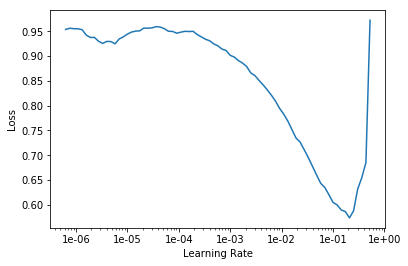

In [15]:
learn.lr_find(); learn.recorder.plot()

In [16]:
lr = 1e-2

We will use `fit_one_cycle` to train the model, because it is awesome. First we train only the head of the model.

In [17]:
learn.fit_one_cycle(6, lr)

epoch,train_loss,valid_loss,accuracy
1,0.113914,0.053512,0.984908
2,0.091127,0.123208,0.966207
3,0.047769,0.051110,0.986549
4,0.044694,0.033662,0.989829
5,0.022703,0.035493,0.989173
6,0.024738,0.034439,0.989501


In [18]:
Then we unfreeze and train the whole model, with lower lr.

SyntaxError: invalid syntax (<ipython-input-18-b87a0d6e4be0>, line 1)

In [19]:
learn.unfreeze()
learn.fit_one_cycle(3, slice(1e-4, 1e-3))

epoch,train_loss,valid_loss,accuracy
1,0.039523,0.039714,0.986877
2,0.025944,0.035891,0.990157
3,0.022283,0.035508,0.989173


In [20]:
learn.save('128')

Let's compute our AUC over the validation set.

In [21]:
p,t = learn.get_preds()
auc_score(p,t)

tensor(0.9928)

# View results

We can reviews our model, to see what it did worng. Probably some of this images even a human has a hard time evaluating.

In [22]:
interp = ClassificationInterpretation.from_learner(learn)
losses,idxs = interp.top_losses()

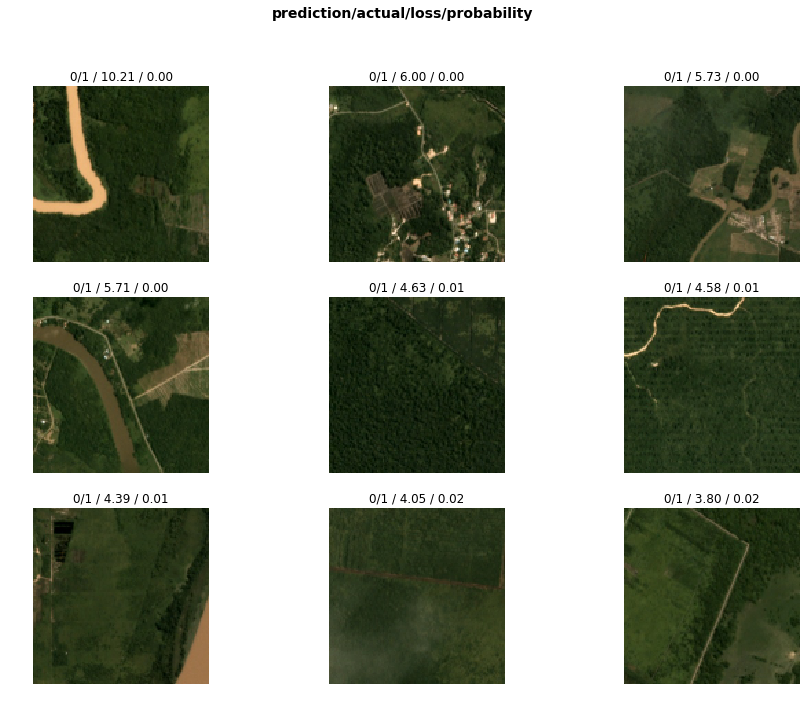

In [23]:
interp.plot_top_losses(9, figsize=(15,11))

## Sub file
We have to create our sub file by concatenating both holdout and test names.

In [24]:
p,t = learn.get_preds(ds_type=DatasetType.Test)

In [25]:
p = to_np(p); p.shape

(6534, 2)

In [26]:
ids = np.array([f.name for f in (test_names+holdout_names)]);ids.shape

(6534,)

In [27]:
#We only recover the probs of having palmoil (column 1)
sub = pd.DataFrame(np.stack([ids, p[:,1]], axis=1), columns=df_sample.columns)

In [28]:
sub.to_csv(work_dir/'sub.csv', index=False)